In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier  
from sklearn.metrics import accuracy_score, f1_score, classification_report,  recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

## 1. Revisión del dataset

In [74]:
df = pd.read_csv('../data/raw/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [76]:
nulos = df.isnull().sum()

columnas_con_nulos = nulos[nulos > 0]

if columnas_con_nulos.empty:
    print("sin nulos")
else:
    print(columnas_con_nulos)

sin nulos


In [77]:
target = df['HeartDisease'].value_counts()
print("Conteo de valores para la columna 'HeartDisease':")
print(target.sort_index())

Conteo de valores para la columna 'HeartDisease':
HeartDisease
0    410
1    508
Name: count, dtype: int64


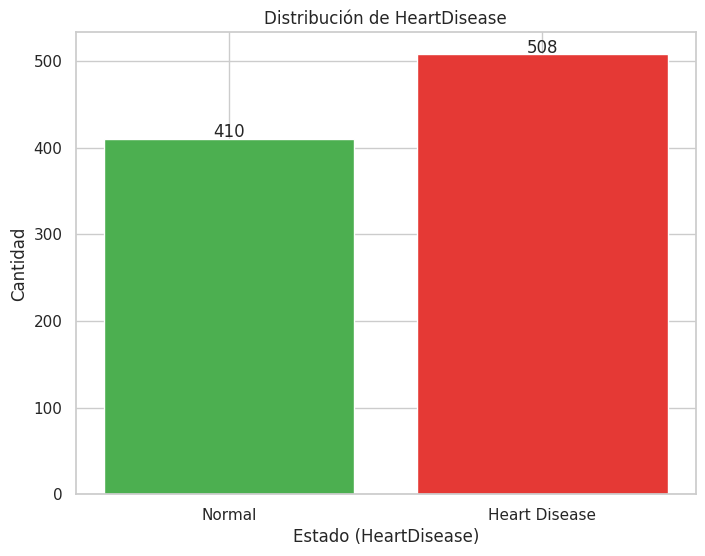

In [78]:
target = df['HeartDisease'].value_counts().sort_index()
labels = {0: 'Normal', 1: 'Heart Disease'}
x = target.index.astype(int)
x_labels = [labels[i] for i in x]

plt.figure(figsize=(8,6))
plt.bar(x, target.values, color=['#4CAF50', '#E53935'])
plt.xticks(x, x_labels)          
plt.xlabel('Estado (HeartDisease)')
plt.ylabel('Cantidad')
plt.title('Distribución de HeartDisease')

# Anotar valores
for i, v in enumerate(target.values):
    plt.text(x[i], v + 2, str(v), ha='center')

plt.show()

In [79]:
# Filtrar y mostrar
zeros_mask = df['Cholesterol'] == 0
print(f"Cantidad de registros con Colesterol 0: {zeros_mask.sum()}")
print(f"Porcentaje del total: {zeros_mask.sum() / len(df):.2%}")

# Ver una muestra
display(df[zeros_mask].head())

Cantidad de registros con Colesterol 0: 172
Porcentaje del total: 18.74%


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1


In [80]:
# Crear la bandera ANTES de reemplazar los ceros
df['Cholesterol_Missing'] = (df['Cholesterol'] == 0).astype(int)

# Reemplazar 0 con NaN para facilitar el manejo
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)

# Calcular medianas por grupos (Sexo y ChestPainType)
# Usamos transform para llenar los NaNs con la mediana de su grupo correspondiente
df['Cholesterol'] = df['Cholesterol'].fillna(
    df.groupby(['Sex', 'ChestPainType'])['Cholesterol'].transform('median')
)

# Verificar si quedan nulos (por si algún grupo no tenía datos)
if df['Cholesterol'].isnull().sum() > 0:
    df['Cholesterol'] = df['Cholesterol'].fillna(df['Cholesterol'].median())
print("Imputación completada.")

Imputación completada.


In [81]:
# Usamos log1p (log(x+1)) para manejar los ceros y abs() para los negativos
df['Oldpeak'] = np.log1p(df['Oldpeak'].abs())

## 2. Separar y Escalar Datos

In [82]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('HeartDisease')
categorical_cols = df.select_dtypes(include=['object']).columns

target = df['HeartDisease']
numeric_features = df[numeric_cols]
categorical_feats = df[categorical_cols]

categorical_encoded = pd.get_dummies(categorical_feats, drop_first=True)
features = pd.concat([numeric_features, categorical_encoded], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target
)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

X_train_scaled

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Cholesterol_Missing,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
485,0.970012,0.339016,-0.515576,1.835497,-0.324520,0.552189,-0.461761,True,True,False,False,False,True,True,True,False
486,0.122028,-1.266031,-0.570838,1.835497,1.689837,-0.340619,-0.461761,True,True,False,False,False,True,False,False,True
117,0.546020,-0.159102,1.713318,1.835497,-0.247045,0.804699,-0.461761,False,False,False,False,False,True,True,True,False
361,-0.725956,1.501291,-0.110323,-0.544812,-0.479470,-1.005254,2.165623,True,False,False,False,True,False,True,True,False
296,-0.407962,0.671094,-0.110323,1.835497,0.101594,0.042898,2.165623,True,False,False,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,-0.301964,0.117630,-1.565551,-0.544812,0.527708,1.164839,-0.461761,True,False,True,False,True,False,False,True,False
201,-0.831954,-0.712567,-0.276108,-0.544812,0.527708,-1.005254,-0.461761,True,False,True,False,True,False,False,False,True
462,0.546020,-0.601874,-0.220847,-0.544812,-0.750634,0.639995,-0.461761,True,False,False,False,True,False,True,False,False
252,0.758016,-0.435834,0.865970,-0.544812,-0.828109,-1.005254,-0.461761,True,False,False,False,False,True,True,False,True


## 3. Modelado y Evaluación 

In [83]:
# Diccionario para guardar resultados de los diferentes modelos
model_scores = {}

In [84]:
'''Entrenamiento con Random Forest'''
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
model_scores['Random Forest'] = recall_rf

print(f"Recall: {recall_rf:.3f}")
print(f"Accuracy: {accuracy_rf:.3f}")
print(f"\nF1: {f1_score(y_test, y_pred_rf):.3f}")
print(classification_report(y_test, y_pred_rf, digits=3))


Recall: 0.882
Accuracy: 0.880

F1: 0.891
              precision    recall  f1-score   support

           0      0.857     0.878     0.867        82
           1      0.900     0.882     0.891       102

    accuracy                          0.880       184
   macro avg      0.879     0.880     0.879       184
weighted avg      0.881     0.880     0.881       184



In [85]:
'''Entrenamiento Regresión Logística'''
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
model_scores['Regresión Logística'] = recall_lr

print(f"Recall: {recall_lr:.3f}")
print(f"Accuracy: {accuracy_lr:.3f}")
print(f"\nF1: {f1_score(y_test, y_pred_lr):.3f}")
print(classification_report(y_test, y_pred_lr, digits=3))



Recall: 0.922
Accuracy: 0.891

F1: 0.904
              precision    recall  f1-score   support

           0      0.897     0.854     0.875        82
           1      0.887     0.922     0.904       102

    accuracy                          0.891       184
   macro avg      0.892     0.888     0.889       184
weighted avg      0.892     0.891     0.891       184



In [86]:
'''Entrenamiento con XGBoost'''
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
model_scores['XGBoost'] = recall_xgb

print(f"Recall: {recall_xgb:.3f}")
print(f"Accuracy: {accuracy_xgb:.3f}")
print(f"\nF1: {f1_score(y_test, y_pred_xgb):.3f}")
print(classification_report(y_test, y_pred_xgb, digits=3))

Recall: 0.873
Accuracy: 0.864

F1: 0.877
              precision    recall  f1-score   support

           0      0.843     0.854     0.848        82
           1      0.881     0.873     0.877       102

    accuracy                          0.864       184
   macro avg      0.862     0.863     0.863       184
weighted avg      0.864     0.864     0.864       184



In [87]:
'''Entrenamiento con SVM'''
svm_rbf = SVC(kernel="rbf", probability=True, random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_svm = svm_rbf.predict(X_test_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
model_scores['SVC'] = recall_svm

print(f"Recall: {recall_svm:.3f}")
print(f"Accuracy: {accuracy_svm:.3f}")
print(f"\nF1: {f1_score(y_test, y_pred_svm):.3f}")
print(classification_report(y_test, y_pred_svm, digits=3))


Recall: 0.902
Accuracy: 0.880

F1: 0.893
              precision    recall  f1-score   support

           0      0.875     0.854     0.864        82
           1      0.885     0.902     0.893       102

    accuracy                          0.880       184
   macro avg      0.880     0.878     0.879       184
weighted avg      0.880     0.880     0.880       184



In [88]:
'''Entrenamiento con Naive Bayes (GaussianNB)'''
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

y_pred_nb = nb.predict(X_test_scaled)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
model_scores['Naive Bayes'] = recall_nb

print(f"Recall: {recall_nb:.3f}")
print(f"Accuracy: {accuracy_nb:.3f}")
print(f"\nF1: {f1_score(y_test, y_pred_nb):.3f}")
print(classification_report(y_test, y_pred_nb, digits=3))


Recall: 0.912
Accuracy: 0.891

F1: 0.903
              precision    recall  f1-score   support

           0      0.887     0.866     0.877        82
           1      0.894     0.912     0.903       102

    accuracy                          0.891       184
   macro avg      0.891     0.889     0.890       184
weighted avg      0.891     0.891     0.891       184



In [89]:
'''Entrenamiento con KNN'''
knn = KNeighborsClassifier(
    n_neighbors=21,
    weights='distance',
    metric='minkowski',
    p=2
)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
model_scores['KNN'] = recall_knn

print(f"Recall: {recall_knn:.3f}")
print(f"Accuracy: {accuracy_knn:.3f}")
print(f"\nF1: {f1_score(y_test, y_pred_knn):.3f}")
print(classification_report(y_test, y_pred_knn, digits=3))

Recall: 0.941
Accuracy: 0.891

F1: 0.906
              precision    recall  f1-score   support

           0      0.919     0.829     0.872        82
           1      0.873     0.941     0.906       102

    accuracy                          0.891       184
   macro avg      0.896     0.885     0.889       184
weighted avg      0.893     0.891     0.891       184



In [90]:

# Función de Evaluación Robusta
def evaluate_cv(models, X, y, k=10):
    results = {}
    print(f"{'Modelo':<20} | {'F1 Score (Promedio)':<20} | {'Desviación Std'}")
    print("-" * 60)
    
    for name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor_v2), ('classifier', model)])
        
        # Cross Validation
        cv_scores = cross_val_score(pipeline, X, y, cv=k, scoring='f1')
        
        results[name] = cv_scores
        print(f"{name:<20} | {cv_scores.mean():.4f}               | +/- {cv_scores.std():.4f}")
    
    return results


## 4. Gráficas


Ranking de los modelos por 'recall':
                       Recall
KNN                  0.941176
Regresión Logística  0.921569
Naive Bayes          0.911765
SVC                  0.901961
Random Forest        0.882353
XGBoost              0.872549


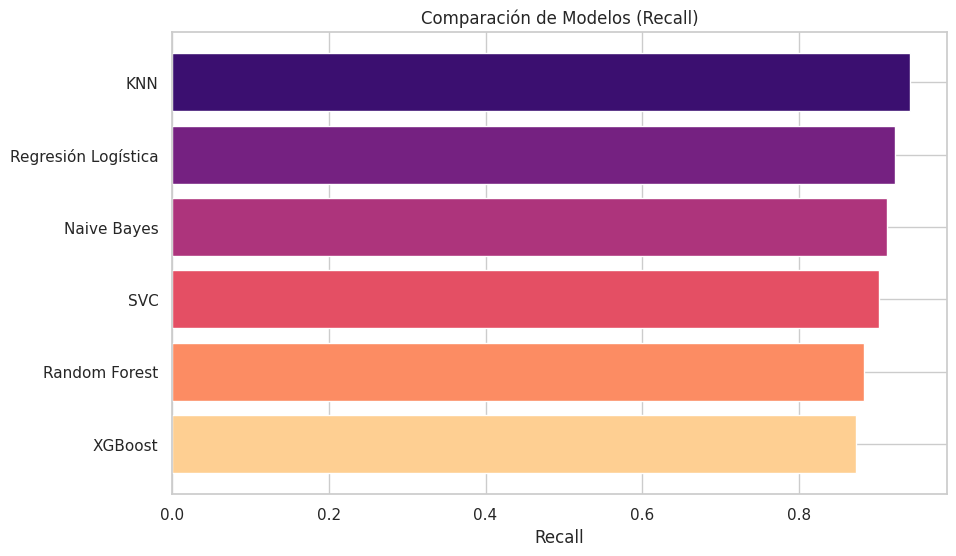

In [91]:
# Mostramos los mejores modelos
# Para ello, nos basamos principalmente en la metrica de 'accuracy
# Ya que nos interesa cuál es el porcentaje de las predicciones correctas
# considerando que el dataset no esta tan desbalanceado. 

scores_df = pd.DataFrame.from_dict(model_scores, orient='index', columns=['Recall'])
scores_df_sorted = scores_df.sort_values(by='Recall', ascending=False)

print("Ranking de los modelos por 'recall':")
print(scores_df_sorted)

n_models = len(scores_df_sorted)
cmap = plt.get_cmap('magma')
colors = cmap(np.linspace(0.2, 0.9, n_models))

plt.figure(figsize=(10, 6))
plt.barh(scores_df_sorted.index, scores_df_sorted['Recall'], color=colors)
plt.xlabel('Recall')
plt.title('Comparación de Modelos (Recall)')
plt.gca().invert_yaxis()
plt.show()

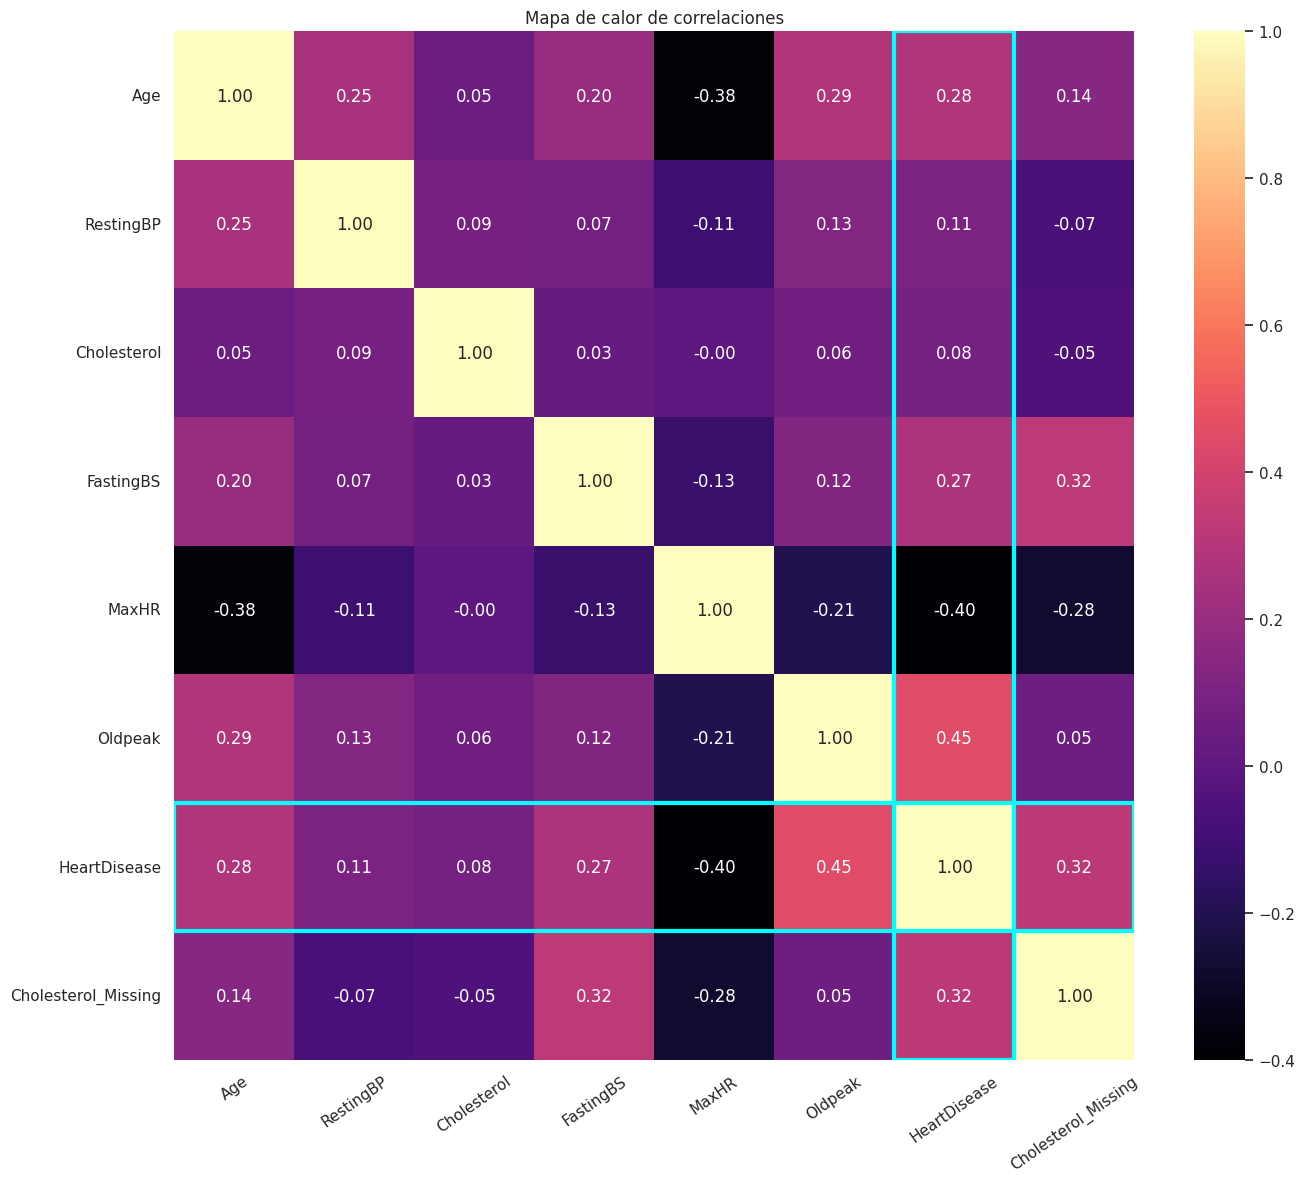

In [92]:
# Mapa de calor de correlaciones

sns.set_theme(style="whitegrid")

columnas_numericas = df.select_dtypes(include=["int64", "float64"]).columns

# Calcular la matriz de correlación
corr_matrix = df[columnas_numericas].corr()

plt.figure(figsize=(14, 12))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="magma",
    fmt=".2f"
)

# Resaltar HeartDisease con un rectángulo
if 'HeartDisease' in corr_matrix.columns:
    # Encontrar el índice de HeartDisease
    hd_idx = corr_matrix.columns.get_loc('HeartDisease')
    
    # Dibujar rectángulo alrededor de la fila
    ax.add_patch(plt.Rectangle((0, hd_idx), len(corr_matrix.columns), 1, 
                                fill=False, edgecolor='cyan', lw=3))
    # Dibujar rectángulo alrededor de la columna
    ax.add_patch(plt.Rectangle((hd_idx, 0), 1, len(corr_matrix.columns), 
                                fill=False, edgecolor='cyan', lw=3))

# Rotar las etiquetas
plt.xticks(rotation=35, ha='center')
plt.yticks(rotation=0)

plt.title("Mapa de calor de correlaciones")
plt.tight_layout()  # Ajustar para que no se corten las etiquetas
plt.show()

In [93]:
print(len(df.select_dtypes(include=["int64", "float64"]).columns))
print(len(df.select_dtypes(include=["object"]).columns))

columnas_objeto = df.select_dtypes(include=["object"]).columns

print("Columnas de tipo objeto:")
for col in columnas_objeto:
    print(col)

print("Columnas numericas:")
for col in columnas_numericas:   
    print(col)

df[["Sex", "HeartDisease"]].head(10)

8
5
Columnas de tipo objeto:
Sex
ChestPainType
RestingECG
ExerciseAngina
ST_Slope
Columnas numericas:
Age
RestingBP
Cholesterol
FastingBS
MaxHR
Oldpeak
HeartDisease
Cholesterol_Missing


,Sex,HeartDisease
0,M,0
1,F,1
2,M,0
3,F,1
4,M,0
5,M,0
6,F,0
7,M,0
8,M,1
9,F,0


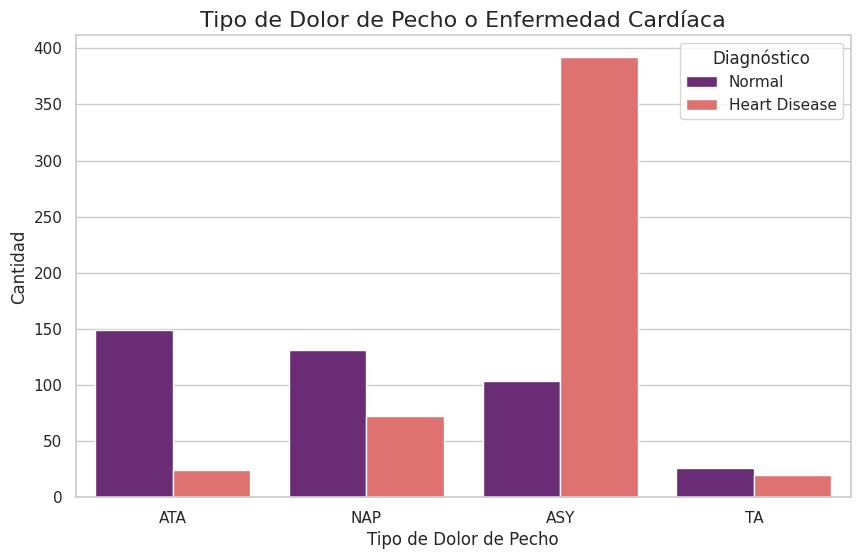

In [94]:
# Variable categorica vs target
# Tipo de dolor de pecho o enfermedad cardíaca

df_plot = df.copy()
df_plot["Diagnóstico"] = df_plot["HeartDisease"].map({0: "Normal", 1: "Heart Disease"})

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_plot,
    x="ChestPainType",
    hue="Diagnóstico",
    palette="magma"
)
plt.title("Tipo de Dolor de Pecho o Enfermedad Cardíaca", fontsize=16)
plt.xlabel('Tipo de Dolor de Pecho', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.show()


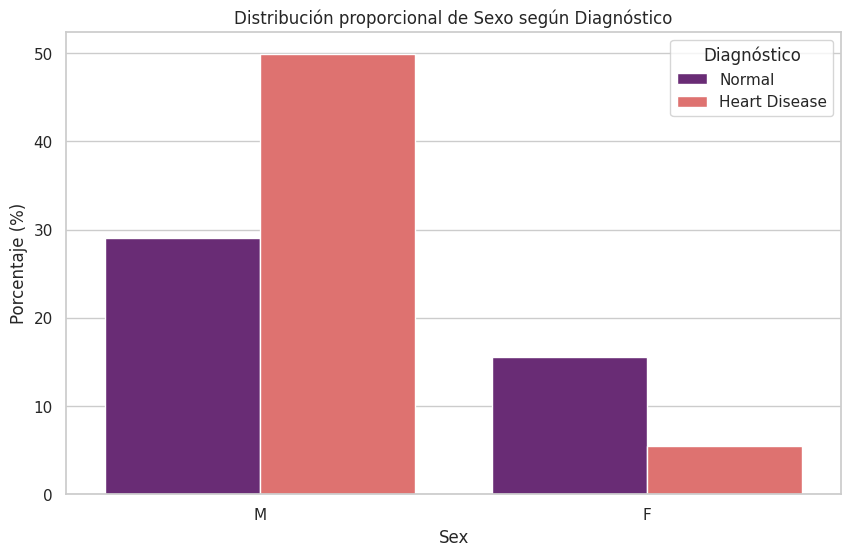

In [95]:
# Sexo vs Enfermedad Cardíaca proporcional

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_plot,
    x="Sex",
    hue="Diagnóstico",
    palette="magma",
    stat="percent"
)
plt.ylabel("Porcentaje (%)")
plt.title("Distribución proporcional de Sexo según Diagnóstico")
plt.show()

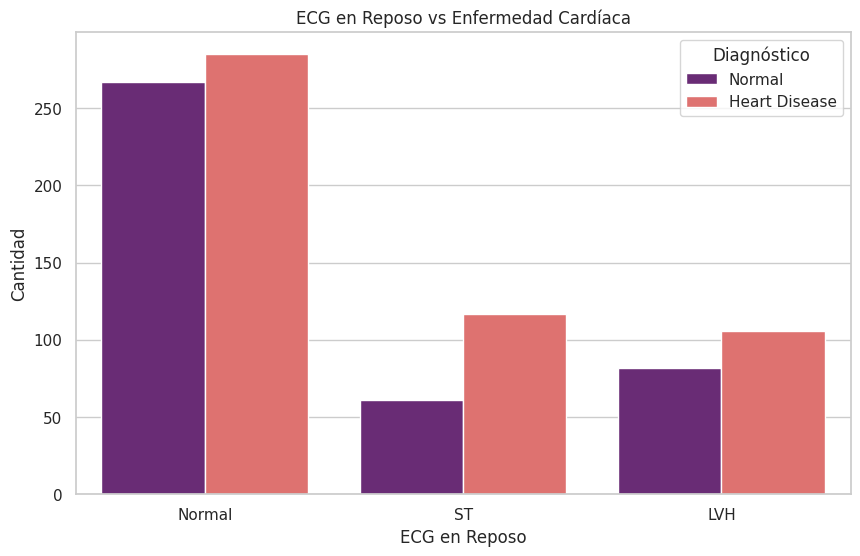

In [96]:
# ECG en Reposo o Enfermedad Cardíaca

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_plot, 
    x="RestingECG", 
    hue="Diagnóstico", 
    palette="magma"
)
plt.title("ECG en Reposo vs Enfermedad Cardíaca")
plt.xlabel("ECG en Reposo")
plt.ylabel("Cantidad")
plt.show()


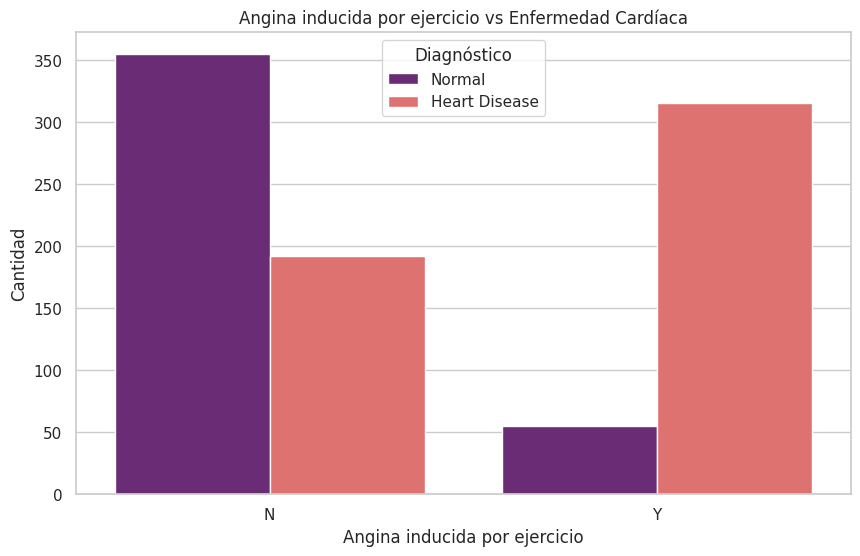

In [97]:
# Angina inducida por ejercicio o Enfermedad Cardíaca

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_plot, 
    x="ExerciseAngina", 
    hue="Diagnóstico", 
    palette="magma"
)
plt.title("Angina inducida por ejercicio vs Enfermedad Cardíaca")
plt.xlabel("Angina inducida por ejercicio")
plt.ylabel("Cantidad")
plt.show()


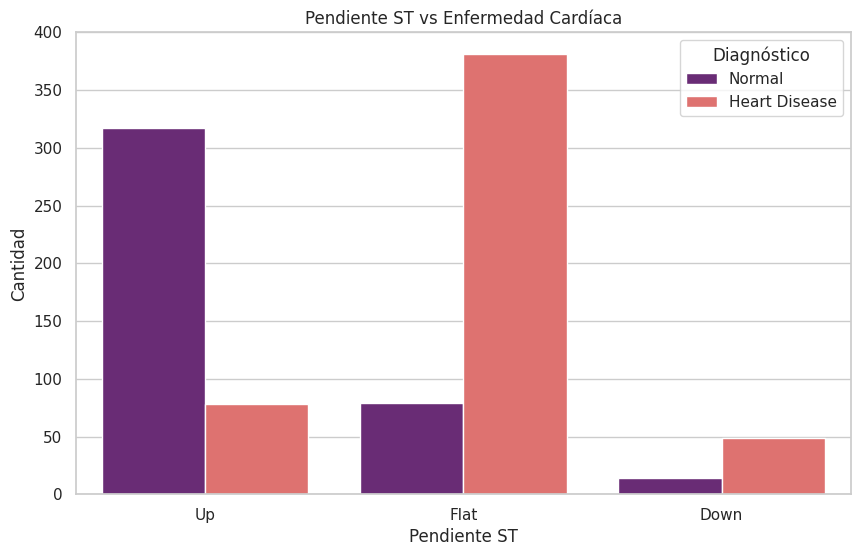

In [98]:
# ST pendiente o Enfermedad Cardíaca

plt.figure(figsize=(10,6))
sns.countplot(
    data=df_plot, 
    x="ST_Slope", 
    hue="Diagnóstico", 
    palette="magma"
)
plt.title("Pendiente ST vs Enfermedad Cardíaca")
plt.xlabel("Pendiente ST")
plt.ylabel("Cantidad")
plt.show()

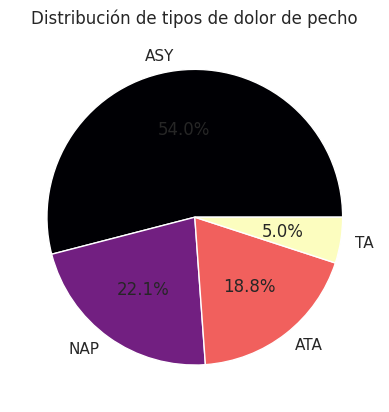

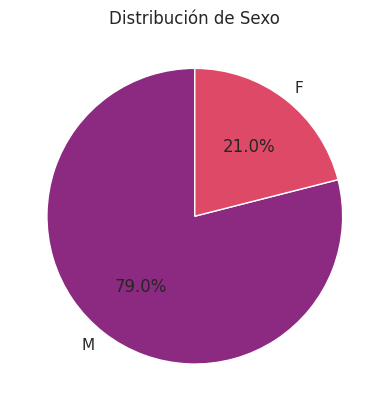

In [99]:
df['ChestPainType'].value_counts().plot.pie(autopct='%1.1f%%', colormap="magma")
plt.title("Distribución de tipos de dolor de pecho")
plt.ylabel("")
plt.show()



sex_counts = df["Sex"].value_counts()
magma_colors = sns.color_palette("magma", n_colors=sex_counts.size + 2)[1:sex_counts.size + 1]

sex_counts.plot.pie(
    autopct="%1.1f%%",
    colors=magma_colors,
    startangle=90
)
plt.title("Distribución de Sexo")
plt.ylabel("")
plt.show()
plt.show()

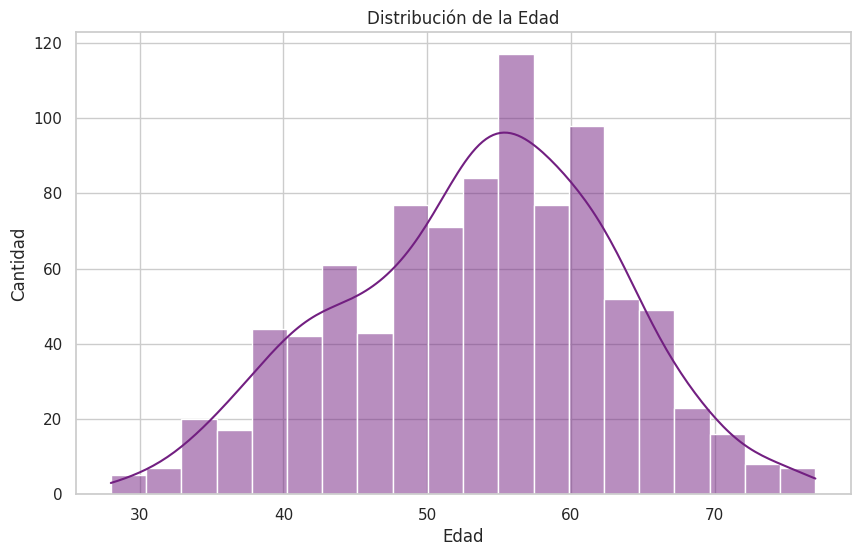

In [100]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

magma_color = sns.color_palette("magma", n_colors=2)[0]
sns.histplot(
    data=df,
    x="Age",
    bins=20,
    kde=True,
    color=magma_color
)

plt.title("Distribución de la Edad")
plt.xlabel("Edad")
plt.ylabel("Cantidad")
plt.show()

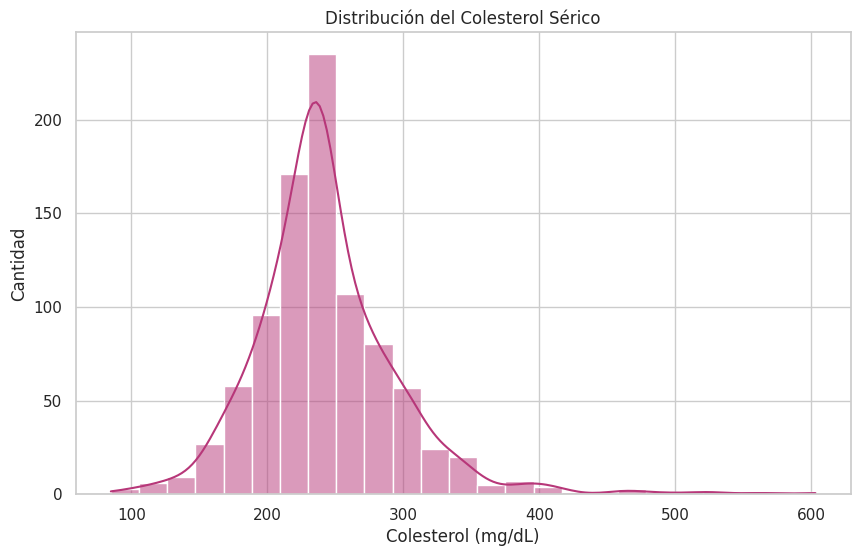

In [101]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

magma_color = sns.color_palette("magma", n_colors=1)[0]
sns.histplot(
    data=df,
    x="Cholesterol",
    bins=25,
    kde=True,
    color=magma_color
)

plt.title("Distribución del Colesterol Sérico")
plt.xlabel("Colesterol (mg/dL)")
plt.ylabel("Cantidad")
plt.show()


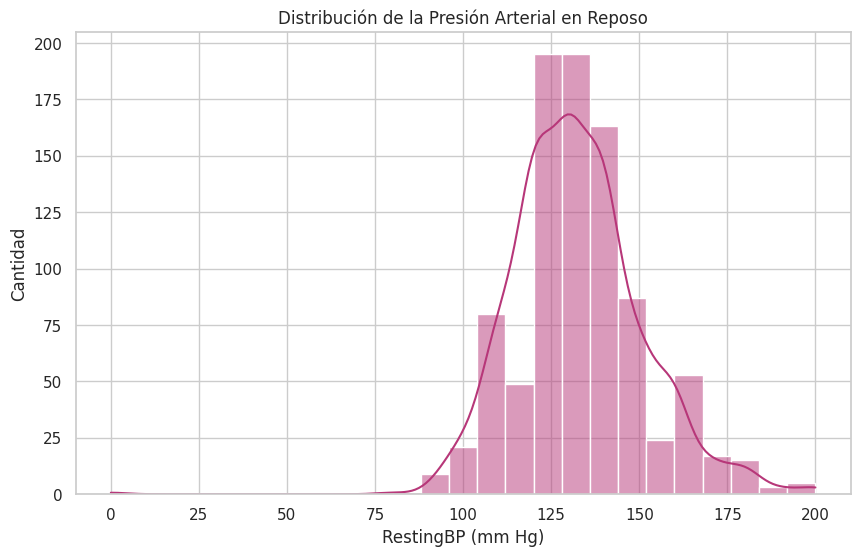

In [102]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

magma_color = sns.color_palette("magma", n_colors=1)[0]
sns.histplot(
    data=df,
    x="RestingBP",
    bins=25,
    kde=True,
    color=magma_color
)

plt.title("Distribución de la Presión Arterial en Reposo")
plt.xlabel("RestingBP (mm Hg)")
plt.ylabel("Cantidad")
plt.show()


/tmp/ipykernel_10831/1591243919.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


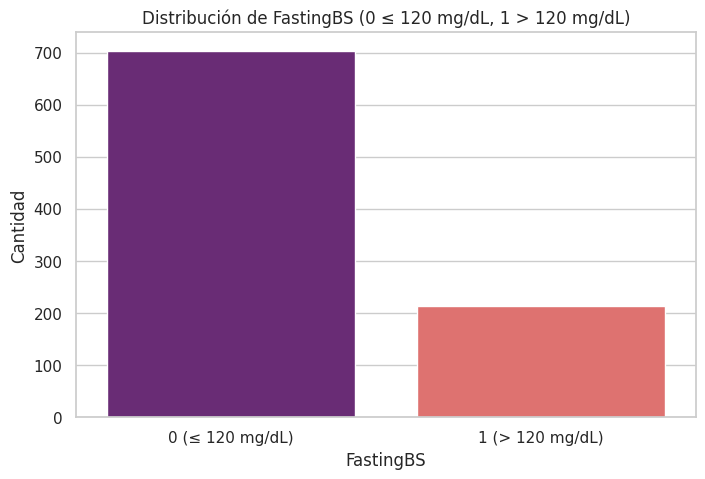

In [103]:
# Distribución de FastingBS (azúcar en sangre en ayunas)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

magma_colors = sns.color_palette("magma", n_colors=2)
sns.countplot(
    data=df,
    x="FastingBS",
    palette=magma_colors
)

plt.title("Distribución de FastingBS (0 ≤ 120 mg/dL, 1 > 120 mg/dL)")
plt.xlabel("FastingBS")
plt.ylabel("Cantidad")
plt.xticks([0, 1], ["0 (≤ 120 mg/dL)", "1 (> 120 mg/dL)"])
plt.show()


/tmp/ipykernel_10831/653623114.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


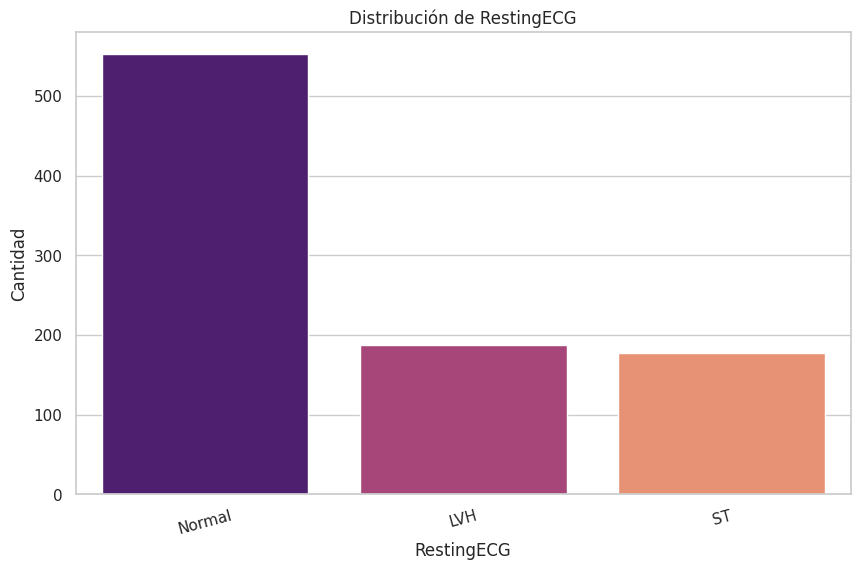

In [104]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

magma_colors = sns.color_palette("magma", n_colors=df["RestingECG"].nunique())
sns.countplot(
    data=df,
    x="RestingECG",
    palette=magma_colors,
    order=df["RestingECG"].value_counts().index
)

plt.title("Distribución de RestingECG")
plt.xlabel("RestingECG")
plt.ylabel("Cantidad")
plt.xticks(rotation=15)
plt.show()


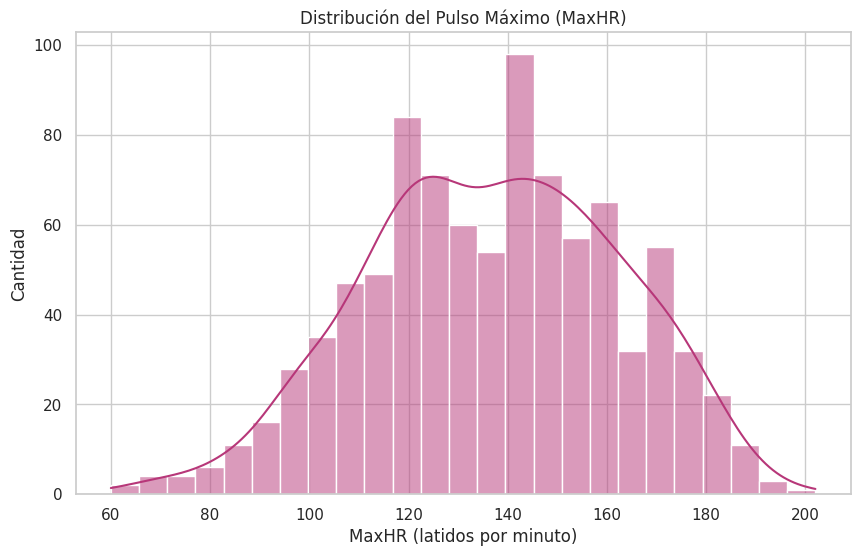

In [105]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

magma_color = sns.color_palette("magma", n_colors=1)[0]
sns.histplot(
    data=df,
    x="MaxHR",
    bins=25,
    kde=True,
    color=magma_color
)

plt.title("Distribución del Pulso Máximo (MaxHR)")
plt.xlabel("MaxHR (latidos por minuto)")
plt.ylabel("Cantidad")
plt.show()


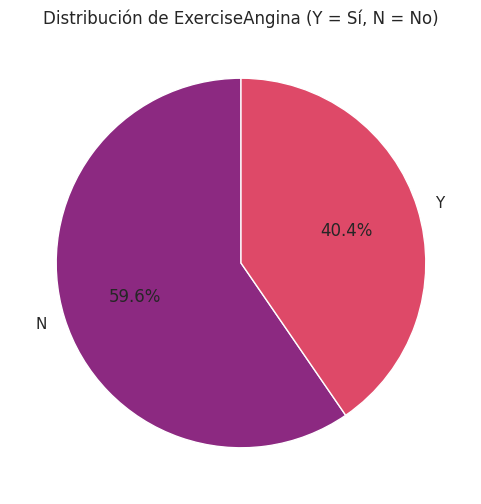

In [106]:
counts = df["ExerciseAngina"].value_counts()
magma_colors = sns.color_palette("magma", n_colors=counts.size + 2)[1:counts.size + 1]

plt.figure(figsize=(6, 6))
counts.plot.pie(
    autopct="%1.1f%%",
    colors=magma_colors,
    startangle=90
)
plt.title("Distribución de ExerciseAngina (Y = Sí, N = No)")
plt.ylabel("")
plt.show()



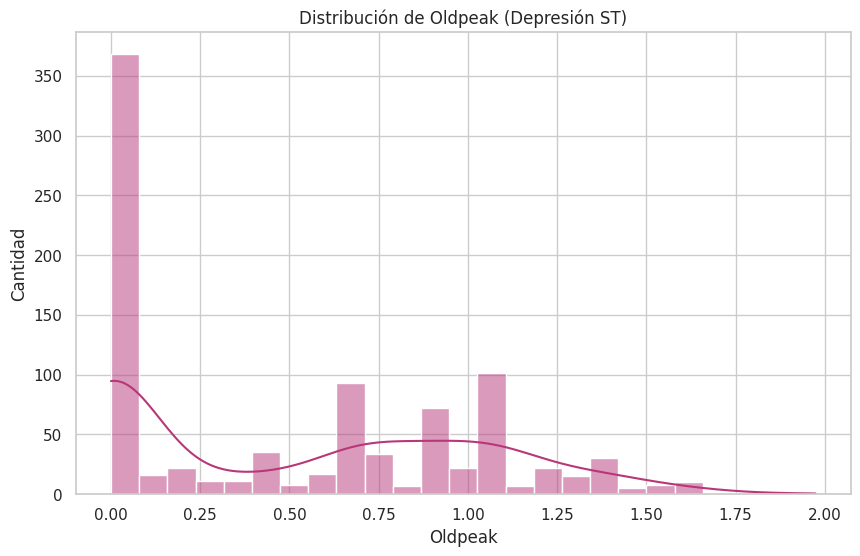

In [107]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

magma_color = sns.color_palette("magma", n_colors=1)[0]
sns.histplot(
    data=df,
    x="Oldpeak",
    bins=25,
    kde=True,
    color=magma_color
)

plt.title("Distribución de Oldpeak (Depresión ST)")
plt.xlabel("Oldpeak")
plt.ylabel("Cantidad")
plt.show()


/tmp/ipykernel_10831/192503019.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


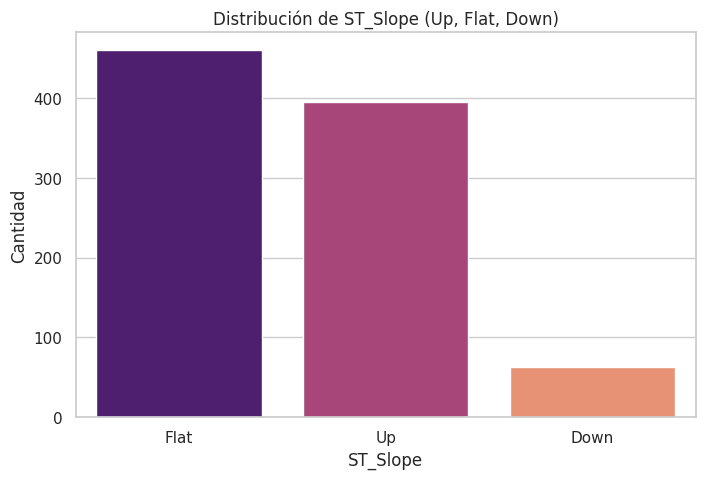

In [108]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

magma_colors = sns.color_palette("magma", n_colors=df["ST_Slope"].nunique())
sns.countplot(
    data=df,
    x="ST_Slope",
    palette=magma_colors,
    order=df["ST_Slope"].value_counts().index
)

plt.title("Distribución de ST_Slope (Up, Flat, Down)")
plt.xlabel("ST_Slope")
plt.ylabel("Cantidad")
plt.show()
